---
title: "Transfer learning with DeepLC"
date: last-modified
author:
- name: Robbin Bouwmeester
  orcid: 0000-0001-6807-7029
  affiliations:
    - VIB-UGent Center for Medical Biotechnology, VIB, Belgium
    - Department of Biomolecular Medicine, Ghent University, Belgium
---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ProteomicsML/ProteomicsML/blob/main/tutorials/retentiontime/_deeplc-transfer-learning.ipynb)

## Transfer learning with DeepLC

In [ ]:
# install library for transfer learning
!pip install deeplcretrainer

In [ ]:
# import deeplc packages
from deeplc import DeepLC
from deeplcretrainer import deeplcretrainer

# Default
from collections import Counter
import os
import urllib.request

# specific packages
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import numpy as np

import tensorflow as tf
from tensorflow.python.eager import context

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# obtain three models for deeplc
urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_1fd8363d9af9dcad3be7553c39396960.hdf5",
    "full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5"
)

urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_8c22d89667368f2f02ad996469ba157e.hdf5",
    "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5"
)

urllib.request.urlretrieve(
    "https://github.com/compomics/DeepLC/raw/master/deeplc/mods/full_hc_hela_hf_psms_aligned_cb975cfdd4105f97efa0b3afffe075cc.hdf5",
    "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
)

('full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5',
 <http.client.HTTPMessage>)

In this tutorial you will learn how to apply transfer learning to DeepLC models. In previous versions of DeepLC the retention time was calibrated to the LC system that the researcher wants to apply the predictions to. This calibration was performed with either a piecewise linear function or in later versions with a GAM. However, this calibration works under the assumption the that elution order is preserved. Transfer learning has been shown to accurately model changes in chromatographic setup while requiring only a small number of peptides.

In [ ]:
# read the input csv file
combined_df = pd.read_csv(
    "https://github.com/ProteomicsML/ProteomicsML/raw/combined_datasets_retention_time/datasets/retentiontime/PRIDE_MQ/PRIDE_MQ.zip?raw=true",
    compression="zip",
    low_memory=False
)

We have the following columns in the downloaded file:

In [ ]:
combined_df.columns

Index(['MQ_seq', 'seq', 'modifications', 'tr', 'project'], dtype='object')

In this file there are multiple projects, some of these have many peptides and retention times associated:

In [ ]:
combined_counter = Counter(combined_df["project"])
combined_counter.most_common()[0:10]

[('PXD028028_A_G_I', 148501),
 ('PXD020019', 98447),
 ('PXD010606_IB', 94779),
 ('PXD023559', 91220),
 ('PXD034196_pro', 88077),
 ('PXD030406', 87908),
 ('PXD019362', 87493),
 ('PXD022614', 86643),
 ('PXD034187_pro', 74438),
 ('PXD021742', 74035)]

The smallest projects in the data set still have over 20 000 peptides:

In [ ]:
combined_counter.most_common()[-10:]

[('PXD024045', 21399),
 ('PXD005346_HeLa_pAA_Rep2', 21112),
 ('PXD020987_third_batch', 20890),
 ('PXD023679', 20837),
 ('PXD022149', 20671),
 ('PXD028125', 20636),
 ('PXD012891', 20531),
 ('PXD010248', 20274),
 ('PXD019957', 20267),
 ('PXD002549', 20175)]

Lets select the project 'PXD002549' which is the project with the smallest number of peptides:

In [ ]:
df = combined_df[combined_df["project"] == combined_counter.most_common()[-1][0]]

From this project we take 90 % of the data for training and early stopping (5 % of this 90 %). The remaining 10 % is used for testing prediction accuracy on unseen peptides.

In [ ]:
df_train = df.sample(frac=0.9)
df_test = df.loc[df.index.difference(df_train.index)]

df_train.fillna("",inplace=True)
df_test.fillna("",inplace=True)

## Calibration

In this section we will use calibration to predict retention times for our project

In [ ]:
%%capture

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make sure we have no NA in the dataframes
df_test['modifications'] = df_test['modifications'].fillna("")
df_train['modifications'] = df_train['modifications'].fillna("")

# Call DeepLC with the downloaded models, say that we use GAM calibration
dlc = DeepLC(
        path_model=["full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5",
                    "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",
                    "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"],
        batch_num=1024000,
        pygam_calibration=True
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_calib = dlc.make_preds(seq_df=df_test)

mae_calib = sum(abs(df_test["tr"]-preds_calib))/len(df_test["tr"].index)
perc95_calib = np.percentile(abs(df_test["tr"]-preds_calib),95)*2
cor_calib = pearsonr(df_test["tr"],preds_calib)[0]

Lets plot the results! These were fitted with a pretrained model and those predictions were calibrated with a GAM model.

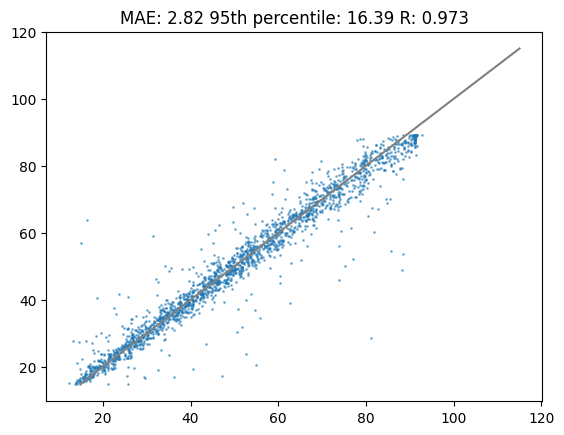

In [ ]:
%matplotlib inline

plt.title(f"MAE: {round(mae_calib,2)} 95th percentile: {round(perc95_calib,2)} R: {round(cor_calib,3)}")
plt.scatter(df_test["tr"],preds_calib,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

## New train

There are quite a few data points so we might actually be able to train a model from the ground up. This means it starts with random parameters in the network and will change it accordingly to the training data.

In [ ]:
%%capture

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will train a new model so we keep the 'mods_transfer_learning' empty
models_subtr = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[],
    freeze_layers=False,
    n_epochs=100
)

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models_subtr,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_newtrain = dlc.make_preds(seq_df=df_test)

mae_newtrain = sum(abs(df_test["tr"]-preds_newtrain))/len(df_test["tr"].index)
perc95_newtrain = np.percentile(abs(df_test["tr"]-preds_newtrain),95)*2
cor_newtrain = pearsonr(df_test["tr"],preds_newtrain)[0]

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Lets plot the results of the newly trained model. As you will see the results are slightly better than calibration. In most cases with less training data the calibration strategy will outperform a newly trained model. What strategy works best, calibration or newly trained, depends highly on the data set.

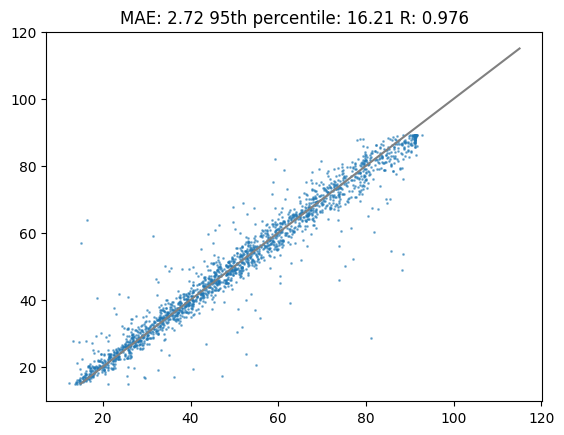

In [ ]:
%matplotlib inline

plt.title(f"MAE: {round(mae_newtrain,2)} 95th percentile: {round(perc95_newtrain,2)} R: {round(cor_newtrain,3)}")
plt.scatter(df_test["tr"],preds_calib,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()

## Transfer learning

Transfer learning is a proven strategy when making predictions for a smaller data set that does not have exactly the same objective. Instead of starting with random starting parameters the training starts with previously trained parameters. This means that it can use information from previously trained on data to obtain a better solution for the current data set.

In [ ]:
%%capture

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# For training new models we need to use a file, so write the train df to a file
df_train.to_csv("train.csv",index=False)
df_train_file = "train.csv"

# Here we will apply transfer learning we specify previously trained models in the 'mods_transfer_learning'
models = deeplcretrainer.retrain(
    [df_train_file],
    mods_transfer_learning=[
        "full_hc_train_pxd001468_1fd8363d9af9dcad3be7553c39396960.hdf5",
        "full_hc_train_pxd001468_8c22d89667368f2f02ad996469ba157e.hdf5",
        "full_hc_train_pxd001468_cb975cfdd4105f97efa0b3afffe075cc.hdf5"
    ],
    freeze_layers=True,
    n_epochs=10,
    freeze_after_concat=1
);

# The following code is not required in most cases, but here it is used to clear variables that might cause problems
_ = tf.Variable([1])

context._context = None
context._create_context()

tf.config.threading.set_inter_op_parallelism_threads(1)

# Make a DeepLC object with the models trained previously
dlc = DeepLC(
        path_model=models,
        batch_num=1024000,
        pygam_calibration=False
)

# Perform calibration, make predictions and calculate metrics
dlc.calibrate_preds(seq_df=df_train)
preds_transflearn = dlc.make_preds(seq_df=df_test)

mae_transflearn = sum(abs(df_test["tr"]-preds_transflearn))/len(df_test["tr"].index)
perc95_transflearn = np.percentile(abs(df_test["tr"]-preds_transflearn),95)*2
cor_transflearn = pearsonr(df_test["tr"],preds_transflearn)[0]

Lets have a look at the transfer learning results. As you can see in the following plot the performance is substantially higher compared to calibration or training a new model.

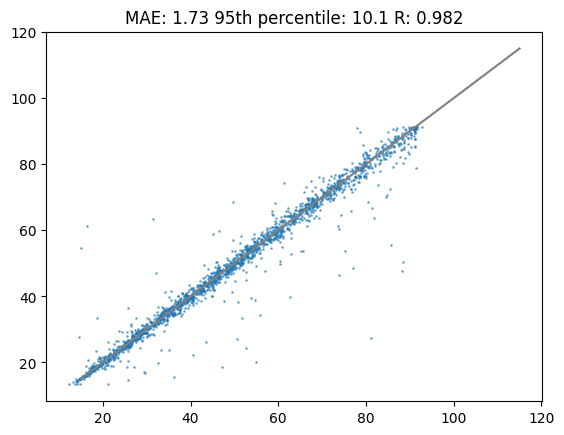

In [ ]:
%matplotlib inline

plt.title(f"MAE: {round(mae_transflearn,2)} 95th percentile: {round(perc95_transflearn,2)} R: {round(cor_transflearn,3)}")
plt.scatter(df_test["tr"],preds_transflearn,s=1,alpha=0.5)
plt.plot([15,115],[15,115],c="grey")
plt.show()